In [ ]:

from sklearn.svm import SVC
from sklearn.svm import SVR
from  Qmapping import get_config
from  Qmapping import evolution
from  Qmapping import CnotGate
from  Qmapping import Hadama
from Qmapping import ZZGate
from Qmapping import gst
from Qmapping import EncodingP
from Qmapping import get_q_kernel
######################################################################################################
################################## useful operators and parameters ###################################
######################################################################################################

C6 = 5.42e-24
desire_rabi = 8*np.pi *1e6
R0=(C6/desire_rabi)**(1/6)

sigx = sigmax()
sigz = sigmaz()
sigy = sigmay()
iid = qutip.qeye(2)
rr = Qobj([[0,0],[0,1]])
ee = Qobj([[1,0],[0,0]])
cnot=tensor(ee, iid)+ tensor(rr, sigx)



class QSVM(self) :
    def __init__(self,task='svr',config={}):
        self.traindata=None
        self.trainedOrNot=False
        self.method = method
        self.config = config
        self.train_set = []
        self.traindata=None
        self.C=1
        if self.config == {} :
            self.default_phys_sys()
        
        
    def default_phys_sys(self):
        self.config['rabi'] = 1
        self.config['detuning'] = 1
        self.config['atomn'] = 10
        self.config['a/R0']=1.2
        self.config['time']=np.pi
        self.config['pos'] = [i* self.config['a/R0']*R0 for i in atomn]


    
    def get_kernel(self, data ,status='training',tier=2,method="", op="x"):
        
        if status=='training':
            if self.trainedOrNot==True:
                print("Error!!!This model has been train.")
                return 
            self.traindata=data
            self.trainedOrNot=True
        self.operator_list = [[] for i in range(self.config['atomn'])]
        matrix = np.ones([dim ,dim])
        for idx ,x in enumerate(matrix) :
            for idy ,y in enumerate(x) :
                self.operator_list[idx].append(Q.form_op([idx , idy] ,Q.rr ,10))
        if self.method == 'rbf' :
            kermnel = fsadf
            pass #sklearn
        elif self.method == 'analog'  :
            pass #analog
        elif self.method == 'digital' :
            pass #digital


        elif self.method == 'analog+digital' :
            # Evolution
            rs = []
            right_gst = gst(self.config['pos'])
            config = get_config(pos)
            if mode == "quera":
                h = HMap(self.config['pos'] ,self.config['atomn'] ,self.config['rabi'],self.operator_list)
                ev=evolution(h,t)
            elif mode == "cnot":
                ev = CnotGate(d)

            for da in Data:
              EP=EncodingP(self.config['atomn'],da,op)
              state= EP * right_gst
              for i in range(tier):
                state= ev * state
                state= EP * state
            rs.append(state)
    
        if status=='training':
            self.trainState=rs
            kernel=get_q_kernel(rs,rs,status = "train")
        else:
            kernel=get_q_kernel(rs,self.trainState)
        return kernel

    
    def fit(self) :
        self.svm = SVC(method = 'precomputed',C=self.C)
        if task == 'svr' :
            self.svm = SVR(method =  'precomputed',C=self.C)

        self.svm.fit(kernel , y_train)
    def test(self, x_test) :
        kernel = get_kernel(x_train , x_test)
        return self.svm.predict()
        
        

In [152]:
all([])

True

In [92]:
import Qmapping as Q
import data_function as df
import numpy as np
import matplotlib.pyplot as plt

In [93]:
f = open('../Datasets/standard_quantum.json', 'r') 
tg = json.load(f)
f.close()
x_train_lst = tg['train']['data']
x_test_lst = tg['test']['data']
y_train = tg['train']['label']
y_test = tg['test']['label']

In [94]:
interval=np.linspace(0,0.06,7)

In [95]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in y_train:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [96]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

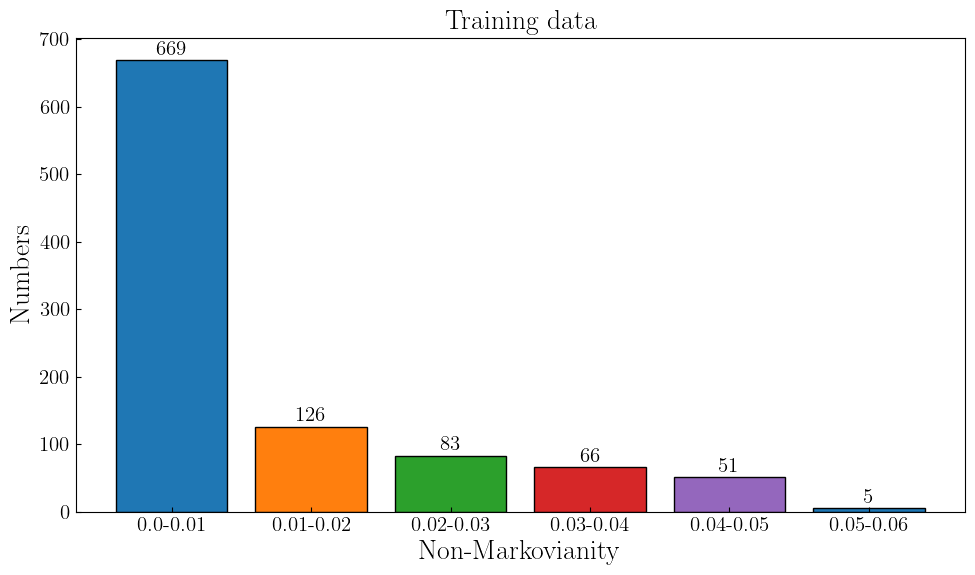

In [97]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Training data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

In [98]:
interval=np.linspace(0,0.06,7)

In [99]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in y_test:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [100]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

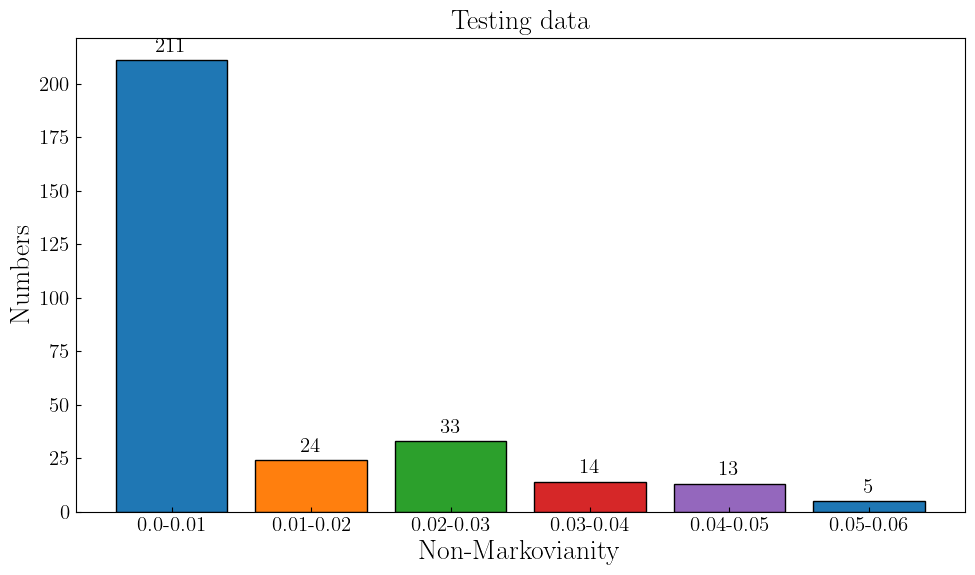

In [101]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Testing data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

In [102]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


In [142]:
class Pca:
    def __init__(self,PCA_n=10):
        self.PCA_n=PCA_n
        self.StandardizeOrNot=True
        self.Fitted=False
    def fitting(self,traindata):
        if self.Fitted:
            print("It has been fitted!! The previous fitting was recovered.")
        if self.StandardizeOrNot == True:
            traindata = scaler.fit_transform(traindata)
        cov_train = np.cov(traindata.T)
        eig_vals, eig_vecs = LA.eig(cov_train)
        sort_indices = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sort_indices]
        eig_vecs = eig_vecs[:, sort_indices]
        self.eig_vec = eig_vecs[:, :self.PCA_n]
        self.Fitted = True
    def transform(self,data):
        if self.StandardizeOrNot == True:
            data = scaler.fit_transform(data)   
        data = np.real(np.dot(data, eig_vec))
        data=np.array(data)
        return data

In [148]:

#step1
scaler = StandardScaler()
train = scaler.fit_transform(x_train_lst)
test = scaler.fit_transform(x_test_lst)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 10 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
x_train_lst = np.real(np.dot(train, eig_vec))
x_test_lst = np.real(np.dot(test, eig_vec))
x_train_lst=np.array(x_train_lst)
x_test_lst=np.array(x_test_lst)